In [1]:
# Cálculo de curvas h - a - d.

import numpy as np
import pandas as pd

from scipy import spatial

from matplotlib import pyplot as plt

import geopandas as gpd
import shapely as shp

In [2]:
# Dirección de los datos.
path = "../Material/Clases/Examen 2/"

# Datos de las estaciones..
estaciones_n = "ESTACIONES_NOROESTE.csv"

In [3]:
# Cargamos la lista de estaciones.
Estaciones = pd.read_csv(path + estaciones_n)

# Nombres de archivos
Estaciones["ARCHIVO"] = Estaciones["ESTACION"].apply(
    lambda x: f"Estacion_{x}__90_dias.csv" )

# Creamos un punto con las coordenadas.
Estaciones["geometry"] = None
Estaciones["geometry"] = gpd.points_from_xy(
    Estaciones["LONGITUD"], Estaciones["LATITUD"])

# Creamos un GeoDataFrame.
Estaciones = gpd.GeoDataFrame(Estaciones, geometry = "geometry", crs = 4326)
# A coordenadas Cónica Conforme de Lambert ITRF2008 ESPSG:6372.
CRS = 6372
Estaciones = Estaciones.to_crs(CRS)

# Actualizamos x, y.
Estaciones["x"] = Estaciones.centroid.x
Estaciones["y"] = Estaciones.centroid.y

In [4]:
# Cargamos los archivos y creamos el pluviograma.

i = 0

# Cargamos el primer archivo.
pluviograma = pd.read_csv(path + Estaciones.loc[i, "ARCHIVO"],
        skiprows = 9, index_col = "Fecha Local", 
        usecols = ["Fecha Local", "Precipitacion (mm)"])
pluviograma.index = pd.to_datetime( pluviograma.index )

# Escogemos las horas en las que hubo tormenta.
pluviograma = pluviograma[ ( pluviograma.index.month.isin([1])
        & pluviograma.index.day.isin([1]) ) ].iloc[50:-9]
# Ponemos a la columna el nombre de la estación.
pluviograma.columns = [ Estaciones.loc[0, "ESTACION"] ]

# Iteramos para el resto de las columnas,
for i in range( 1, Estaciones.shape[0] ): 
    df = pd.read_csv(path + Estaciones.loc[i, "ARCHIVO"],
        skiprows = 9, index_col = "Fecha Local", 
        usecols = ["Fecha Local", "Precipitacion (mm)"])
    df.index = pd.to_datetime( df.index )
    df = df[ ( df.index.month.isin([1])
        & df.index.day.isin([1, 1]) ) ].iloc[50:-9]
    
    # Agregamos la columna al DataFrame.
    pluviograma[ Estaciones.loc[i, "ESTACION"] ] = df["Precipitacion (mm)"]

# Para las estaciones insulares agregamos las mediciones incompletas.
pluviograma.iloc[-1, 1] = 0
pluviograma.iloc[-4, 1] = 0.2
pluviograma.iloc[-7, 1] = 0.5

# Invertimos el orden temporal del pluviograma.
pluviograma = pluviograma.iloc[::-1]

# Calculamos la precipitación total para cada estación.
Estaciones["hp_TOT"] = pluviograma.sum().to_numpy()

<AxesSubplot:xlabel='Fecha Local'>

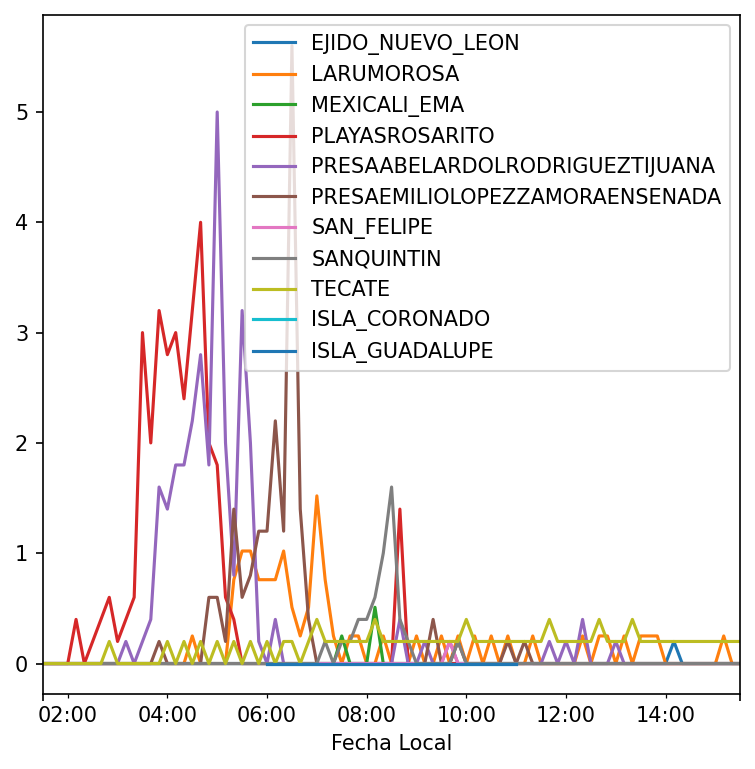

In [5]:
# Precipitación durante la tormenta.

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(6, 6)
fig.set_dpi(150) 

# Graficamos sin las estaciones insulares de SEMAR.
pluviograma.drop( ["ISLA_CORONADO", "ISLA_GUADALUPE"], axis = 1).plot(ax = ax)
# Graficmamos las estaciones de SEMAR con diferente dt.
pluviograma[["ISLA_CORONADO", "ISLA_GUADALUPE"]].iloc[27::3].plot(ax = ax)

In [6]:
# Cargamos las Subcuencas.

# Region hidrológica a usar.
RH = "RH01"

# Cargamos archivo.
subc = gpd.read_file(path + "subcuenca.shp")
# A coordenadas Cónica Conforme de Lambert ITRF2008 ESPSG:6372.
subc = subc.to_crs(crs = CRS)
# Cramos una columna con la región hidrológica.
subc["CVE_RH"] = subc["CVE_SUBCUE"].apply(lambda x: x[0:4])

# Agramos área y perímetro.
subc["AREA"] = subc.area
subc["PERIMETRO"] = subc.length

In [7]:
# Polígonos de Thiessen

# Agregamos estaciones virtuales en los límites de la extensión de la cuenca.
# Alejamos los puntos de la cuenca para que los nuevos polígonos de Thiessen
# no toquen la cuenca.
buffer = 110000
# Obtenemos la extensión de la cuenta.
bounds = subc[subc["CVE_RH"] == RH].total_bounds
# Creamos los puntos en las esquinas e intermedio entre cada vértice
# agregando el valor del buffer.
bbox = [ [ bounds[0] - buffer, bounds[1] - buffer ],
         [ ( bounds[0] + bounds[2] ) / 2, bounds[1] - buffer ],
         [ bounds[2] + buffer, bounds[1] - buffer ],
         [ bounds[2] + buffer, ( bounds[1] + bounds[3] ) / 2 ],
         [ bounds[2] + buffer, bounds[3] + buffer ],
         [ ( bounds[0] + bounds[2] ) / 2, bounds[3] + buffer ],
         [ bounds[0] - buffer, bounds[3] + buffer ],
         [ bounds[0] - buffer, ( bounds[1] + bounds[3] ) / 2 ] ]
# Creamos una lista vacía con las geometrías de los puntos.
for i in range( len(bbox) ):
    bbox[i] = ( [f"B{i + 1}"] + [None] * ( Estaciones.shape[1] - 5 )
        + [shp.geometry.Point(bbox[i]), bbox[i][0], bbox[i][1] ] + [None] )
# Agregamos las estaciones virtuales.
Estaciones = pd.concat([Estaciones,
    pd.DataFrame(bbox, columns = Estaciones.columns)]
    ).reset_index( drop = True )

# Creamos los polígonos de Thiessen.
Thiessen = spatial.Voronoi( Estaciones[ ["x", "y"] ] )
# Extraemos los polígonos de Thiessen, los convertimos en geometrías
# de Shapely y los agregamos al geoDataFrame de Estaciones.
# Lista de geometrías de Shapely.
Poly_th = []
# Iteramos para cada lista de vértices que forman un polígono.
for i in Thiessen.point_region:
    # Creamos la lista de vértices.
    Ver_th = []
    # Saltamos las listas vacías.
    if len(Thiessen.regions[i]) == 0: pass
    else:
        if -1 in Thiessen.regions[i]:
            Poly_th.append( shp.geometry.Polygon( ) )
        # Agregamos cada vértice que corresponde al polígono de Thiessen.
        else:
            for j in Thiessen.regions[i]:
                Ver_th.append( Thiessen.vertices[j] )
            # Agregamos nuevamente el primer vértice para cerrar el polígono.
            Ver_th.append( Ver_th[0] )
            # Convertimos a geometría de shapely.
            Poly_th.append( shp.geometry.Polygon( Ver_th ) )
# Creamos una columna del GeoDataframe con los polígonos de Thiessen.
Estaciones["Thiessen"] = Poly_th
# Establecemos como la geometría de trabajo.
Estaciones = Estaciones.set_geometry("Thiessen")

# Retiramos las estaciones virtuales.
Estaciones = Estaciones.iloc[:-8].copy()
# Recuperamos la proyección geográfica.
Estaciones.set_crs(subc.crs, inplace = True)
# Establecemos la precipitación como valor numérico.
Estaciones["hp_TOT"] = Estaciones["hp_TOT"].astype(float)

In [8]:
# Isoyetas

# Calculamos las isoyetas y las guardamos en una variable.
isoyetas = plt.tricontour( Estaciones["x"],
    Estaciones["y"], Estaciones["hp_TOT"], levels = 15 )
# Extraemos las isoyetas y las convertimos en curvas de Shapely.
# Lista con el nivel de las isoyetas repetido
# por cada isoyeta que haya en ese nivel.
hp_level = []
# Cantidad de isoyetas que tiene un nivel.
level_n  = []
# Curvas de cada isoyeta.
level_c  = []
# Iteramos para todos los grupos de isoyetas allsegs.
# Evitamos el primer y último grupo que están vacíos.
for i in range( len(isoyetas.allsegs[1:-1]) ):
    # Contamos la cantidad de isoyetas que hay en un grupo, lo agregamos
    # a la lista level_n e imprimimos los valores.
    level_n.append( len( isoyetas.allsegs[1 + i] ) )
    # Copiamos el nivel de la isoyeta tantas
    # veces como isoyetas haya en ese nivel.
    hp_level = hp_level + [isoyetas.levels[i]] * level_n[i]
    # Entramos en cada grupo i, que tiene una cantidad level_n[i]
    # de elementos dentro, convertimos cada elemento en una
    # geometría de shapely y lo metemos dentro de una lista
    # de una sola dimensión (como hacer flatten).
    for j in range( 0, level_n[i] ):
        level_c.append( shp.geometry.LineString(isoyetas.allsegs[i + 1][j]) )
# Creamos un DataFrame con los niveles de isoyetas.
df_is = pd.DataFrame(hp_level, columns = ["hp [mm]"])
# Agregamos las geometrías de shapely.
df_is["geometry"] = level_c
# Convertimos en un GeoDataFrame.
df_is = gpd.GeoDataFrame(df_is)
# Establecemos que hemos estado trabajando con coordenadas UTM 11N (m).
df_is = df_is.set_crs(CRS)
# Evitamos graficar.
plt.close()

In [9]:
# Extraemos la subcuenca con la que trabajaremos.
Subcuenca = subc[ subc["CVE_SUBCUE"] == "RH01Bd" ].reset_index(drop = True)

# Escogemos la parte de cada polígono de Thiessen que cae dentro de la cuenca.
Estaciones[Subcuenca.loc[0, "CVE_SUBCUE"]] = ( Estaciones[ "Thiessen"
    ].intersection( Subcuenca.loc[0, "geometry"] ) )
Estaciones = Estaciones.set_geometry(Subcuenca.loc[0, "CVE_SUBCUE"]).copy()
# Eliminamos las estaciones que no son relevantes para la cuenca.
subc_th = Estaciones[ ~ Estaciones.is_empty ].reset_index(drop = True)
# Área de las áreas de influencia.
subc_th[f"{Subcuenca.loc[0, 'CVE_SUBCUE']}_AREA"] = subc_th.area

# Obtenemos la parte de la línea de cada isoyeta que cae dentro de la cuenca.
df_is[Subcuenca.loc[0, "CVE_SUBCUE"]] = df_is["geometry"
    ].intersection( Subcuenca.loc[0, "geometry"] )
#subc_is[f"{Subcuenca.loc[0, 'CVE_SUBCUE']}_POLY"] = ( subc_is.set_geometry(
#    "IS_TOT").intersection( Subcuenca.loc[0, "geometry"] ) )
subc_is = df_is.set_geometry(Subcuenca.loc[0, "CVE_SUBCUE"]).copy()
# Eliminamos las isoyetas que no cruzan la subcuenca.
subc_is = subc_is[ ~ subc_is.is_empty ].reset_index(drop = True)

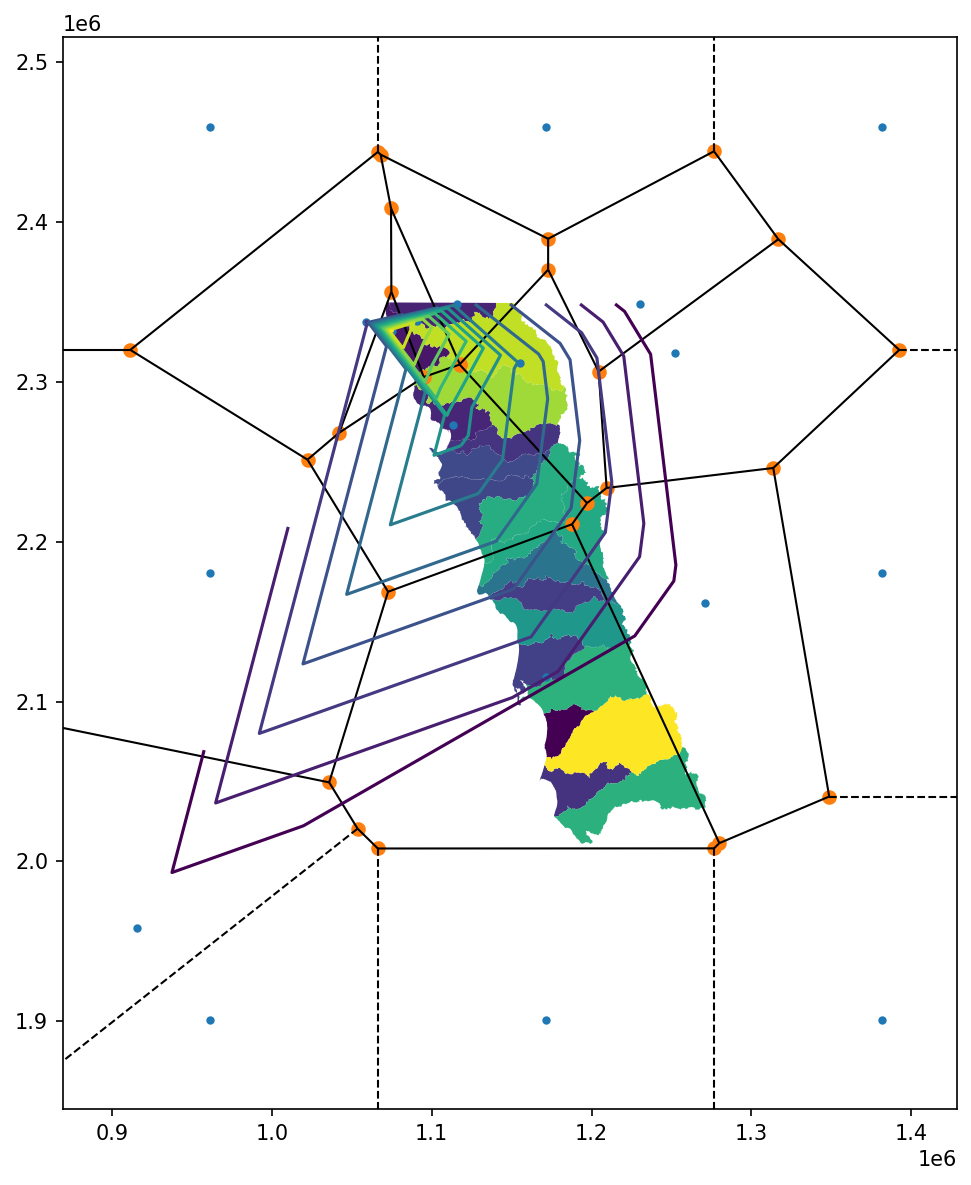

In [10]:
# Polígonos de Thiessen + isoyetas.

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(8, 8)
fig.set_dpi(150) 

# Graficamos las subcuenca.
subc[subc["CVE_RH"] == "RH01"].plot("AREA", ax = ax)
# Graficamos los polígonos de Thiessen.
spatial.voronoi_plot_2d(Thiessen, ax = ax)
# Graficamos las isoyetas.
df_is.plot("hp [mm]", ax = ax)

fig.tight_layout()
plt.show()

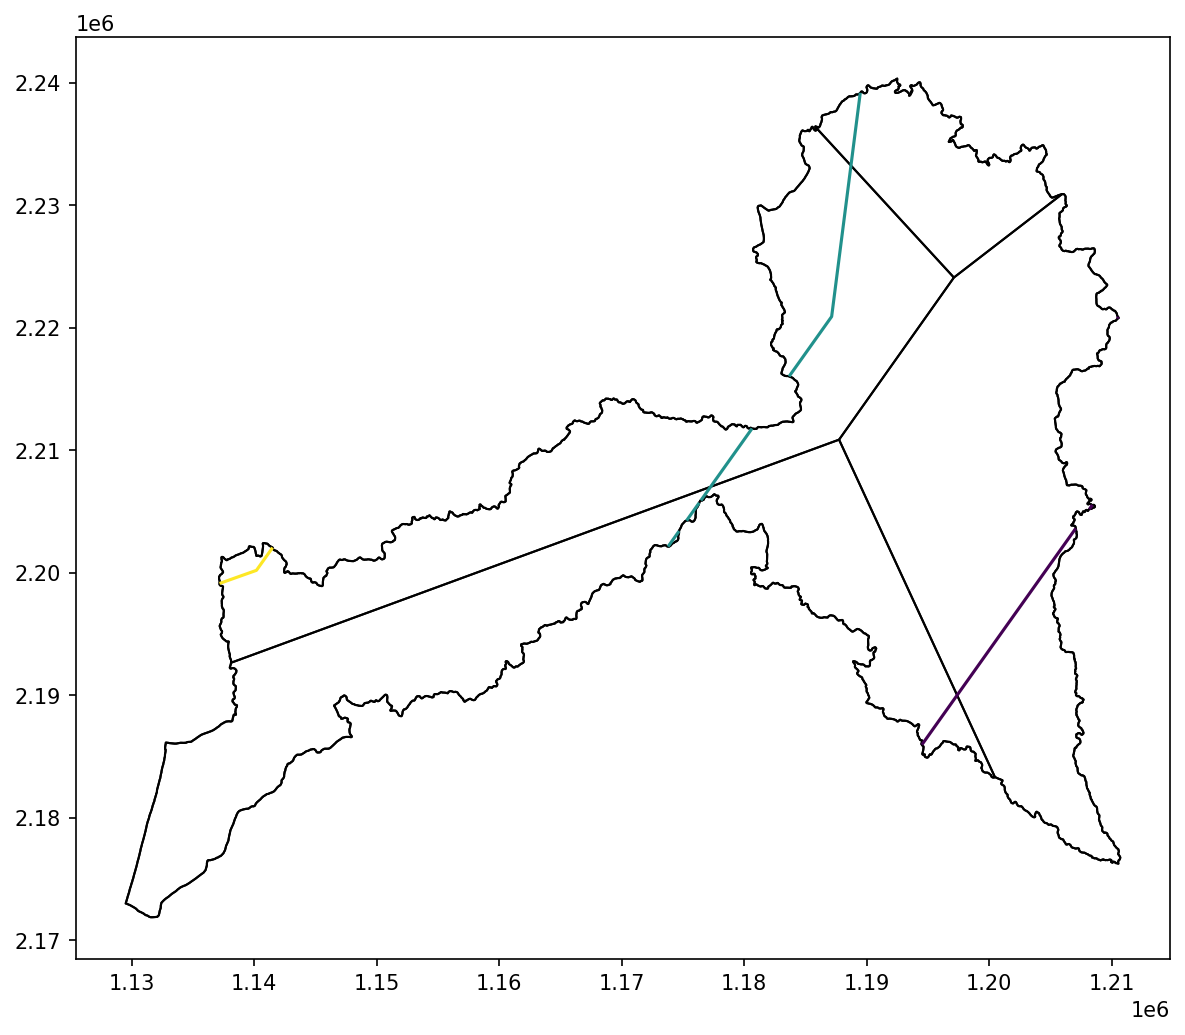

In [11]:
# Polígonos de Thiessen e isoyetas que cruzan la cuenca.

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(8, 8)
fig.set_dpi(150) 

# Graficamos la subcuenca.
Subcuenca.plot(ax = ax, color = "None", edgecolor = "k")
# Graficamos los polígonos de Thiessen.
subc_th.plot(ax = ax, color = "None", edgecolor = "k")
# Graficamos las isoyetas.
subc_is.plot("hp [mm]", ax = ax)

fig.tight_layout()
plt.show()

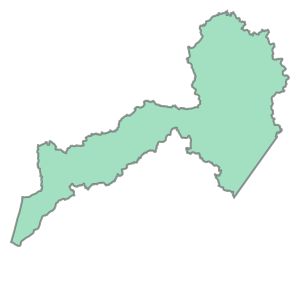

In [12]:
i = 0
j = 0

shp.ops.split( Subcuenca.loc[0, "geometry"],
    subc_is.loc[i, "geometry"] ).geoms[j]

In [13]:
# Área incremental de isoyetas.

# Geometrías a utilizar dentro del split para el área incremental de isoyetas.
j = [ [0], [1, 4], [1] ]
m = []
# Iteramos para todas las isoyetas.
for i in range(subc_is.shape[0]):
    g = []
    # Curva de la isoyeta.
    l = subc_is.loc[i, "geometry"]
    # Unimos todas las geometrías del área incremental isoyetas.
    for k in j[i]:
        g.append( shp.ops.split( Subcuenca.loc[0, "geometry"], l).geoms[k] )
    # Agregamos la geometría.
    m.append( shp.geometry.MultiPolygon(g) )
# Agregamoslas geometrías creadas.
subc_is[f"{Subcuenca.loc[0, 'CVE_SUBCUE']}_POLY"] = m

# Áreas de influencia para cada Ci, área incremental de isoyetas.
# Iteramos de atrás hacia adelante para cada isoyeta (mayor a menor).
for i in reversed( range(subc_is.shape[0]) ):
    # La geometría es la intersección del área incremental de isoyeta Ci y los
    # polígonos de Thiessen dentro de la cuenca.
    subc_th[f"IS_{subc_is.index[i]}"] = subc_th[
        f"{Subcuenca.loc[0, 'CVE_SUBCUE']}" ].intersection(
        subc_is.loc[ i, f"{Subcuenca.loc[0, 'CVE_SUBCUE']}_POLY" ] )
    # Calculamos el área.
    subc_th[f"IS_{subc_is.index[i]}_AREA"] = subc_th[
        f"IS_{subc_is.index[i]}"].area

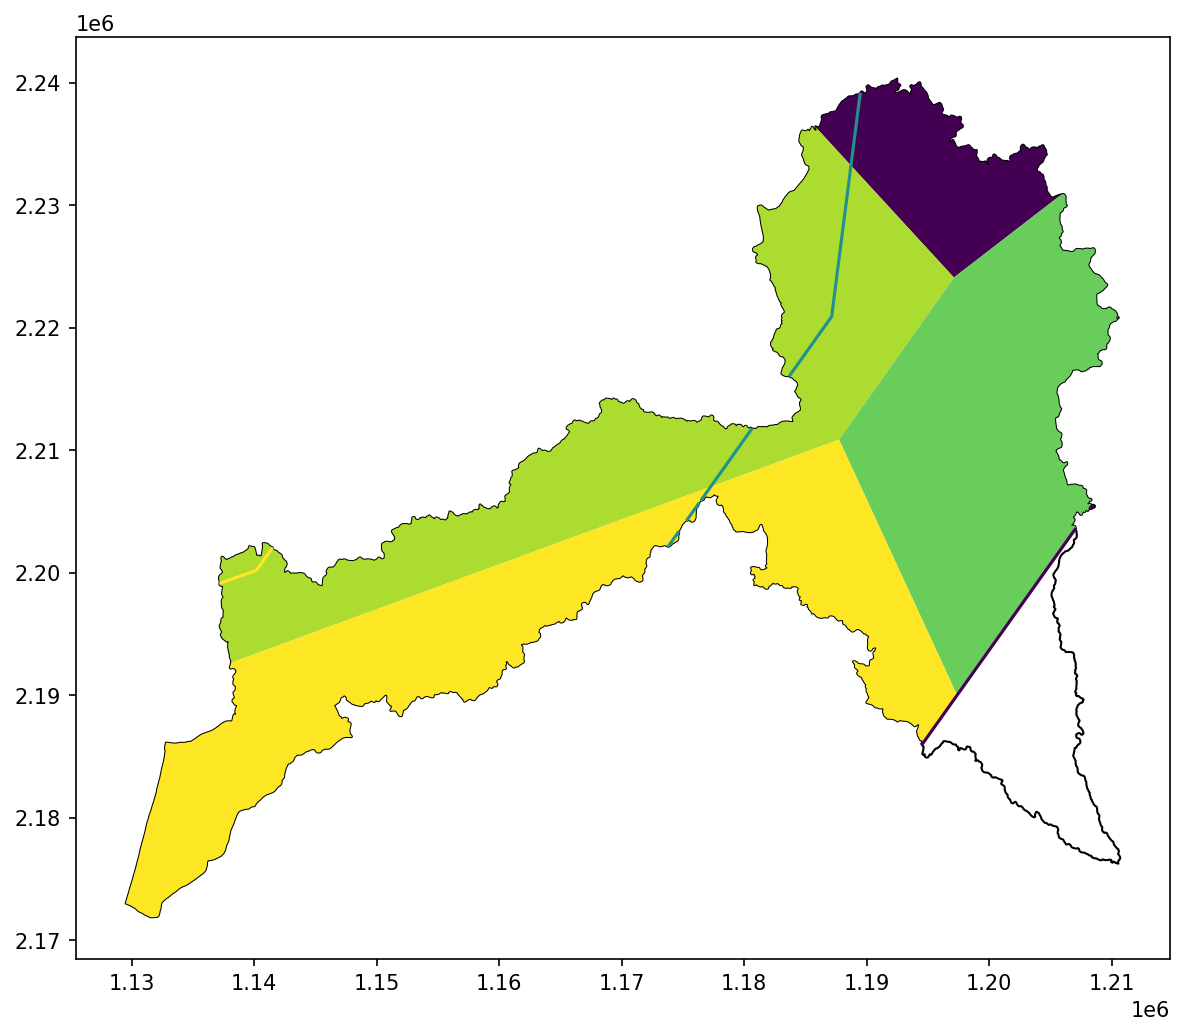

In [14]:
# Polígonos de Thiessen + áreas isoyetas incrementales (Ci para h - a - d)

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(8, 8)
fig.set_dpi(150) 

i = 0

# Graficamos la subcuenca.
Subcuenca.plot(ax = ax, color = "None", edgecolor = "k")
# Graficamos los polígonos de Thiessen para las áreas isoyetas incrementales.
subc_th.set_geometry(f"IS_{i}").plot(f"IS_{i}_AREA", ax = ax)
# Graficamos las isoyetas.
subc_is.set_geometry(Subcuenca.loc[0, "CVE_SUBCUE"]).plot("hp [mm]", ax = ax)

fig.tight_layout()
plt.show()

In [15]:
# Precipitación media por Thiessen.

# Creamos una lista con nombres de las isoyetas y sus áreas.
areas_n = ( [ Subcuenca.loc[0, "CVE_SUBCUE"] ]
    + [ f"IS_{x}"for x in range(subc_is.shape[0]) ] )
areas_na = [f"{x}_AREA" for x in areas_n]
# Precipitación media por Thiessen.
hp_th = []
for i in range( len(areas_na) ):
    hp_th.append( ( subc_th["hp_TOT"] * subc_th[areas_na[i]] ).sum()
        / subc_th[areas_na[i]].sum() )
# Creamos un DataFrame con la precipitación media.
areas_is = pd.DataFrame( hp_th, columns = ["hp_th"],
    index = areas_n ).reset_index()
areas_is = areas_is.rename( {"index": "AREA"}, axis = 1)

In [16]:
# Precipitación media por isoyetas.

# Áreas entre isoyetas.
# Diferencia entr el área de dos isoyetas contiguas.
# Los casos borde son ligeramente diferente (ejemplo: toda la subcuenca menos
# primer isoyeta).
m = []
for i in reversed(range( areas_is.shape[0] )):
    if i == areas_is.shape[0] - 1:
        m = [ subc_is.loc[i - 1, f"{areas_n[0]}_POLY"] ] + m
    elif i > 0:
        m = ( [ subc_is.loc[i - 1, f"{areas_n[0]}_POLY"]
            .difference( subc_is.loc[ i, f"{areas_n[0]}_POLY"] ) ] + m )
    else:
        m = ( [ Subcuenca.loc[0, "geometry"].difference(
            subc_is.loc[i, f"{areas_n[0]}_POLY"] ) ] + m )
# Agregamos las áreas entre isoyetas al DataFrame.
areas_is["IS_GEOM"] = m
areas_is = gpd.GeoDataFrame( areas_is, geometry = "IS_GEOM" )
areas_is["IS_AREA"] = areas_is.area
# Calculamos el paso entre cada isoyeta.
step = subc_is.at[ 1, "hp [mm]" ] - subc_is.at[ 0, "hp [mm]" ]
mid = step / 2
# Calculamos la precipitación entre isoyetas.
m = ( [subc_is.at[ 0, "hp [mm]" ] - mid ]
    + list(subc_is[ "hp [mm]" ] + mid) )
# Agregamos la precipitación entre isoyetas al DataFrame.
areas_is["hp_area"] = m
# Precipitación media por isoyetas.
m = []
for i in range(areas_is.shape[0]):
    m.append( ( areas_is.loc[i:, "hp_area"]
        * areas_is.loc[i:, "IS_AREA"] ).sum()
        / areas_is.loc[i:, "IS_AREA"].sum() )
# Factor de ajuste.
areas_is["hp_is"] = m
areas_is["Fa"] = areas_is["hp_is"] / areas_is["hp_th"]

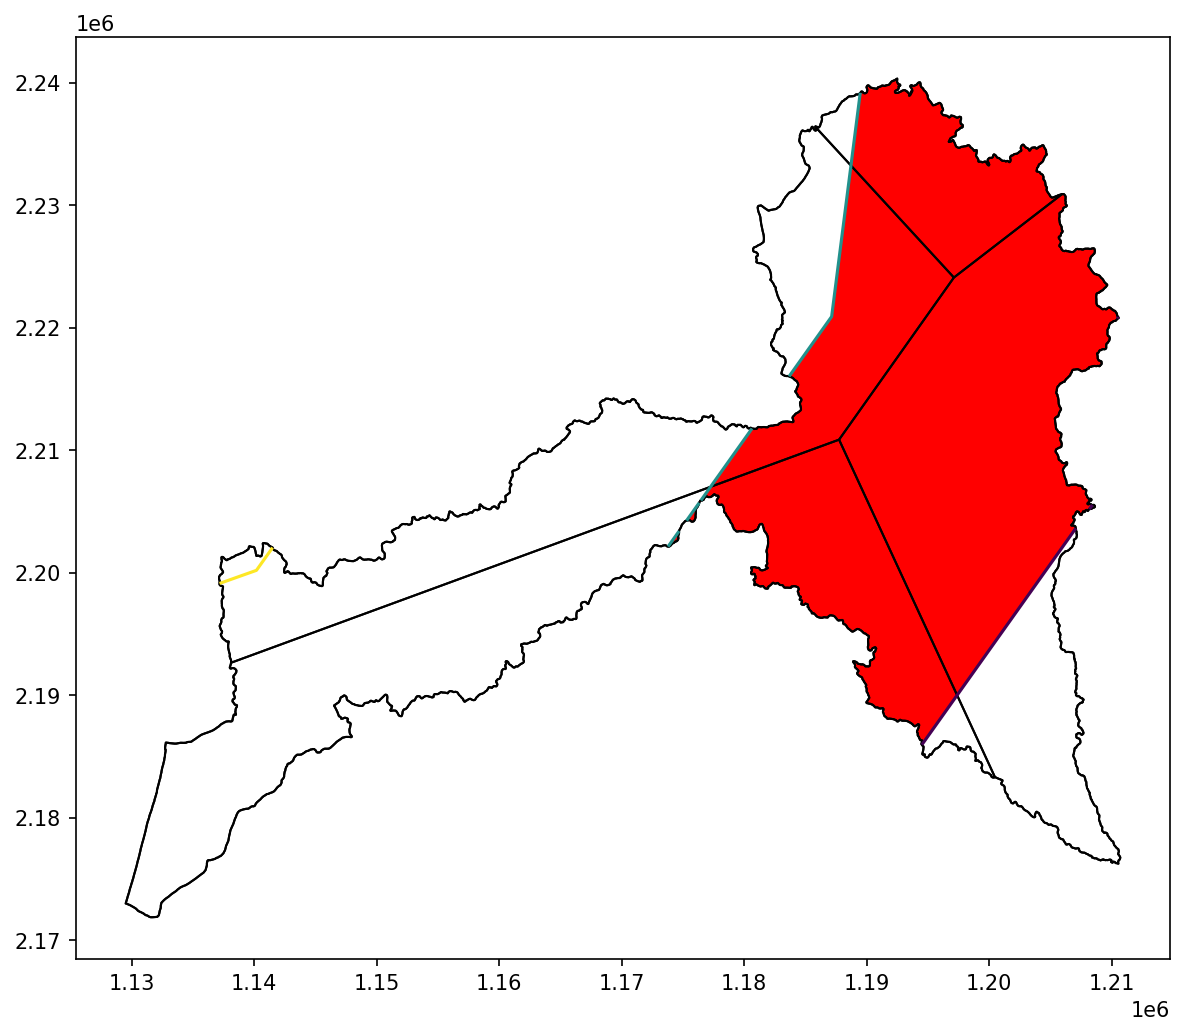

In [17]:
# Polígonos de Thiessen + areas entre isoyetas.

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(8, 8)
fig.set_dpi(150) 

i = 1

# Graficamos la subcuenca.
Subcuenca.plot(ax = ax, color = "None", edgecolor = "k")
# Graficamos los polígonos de Thiessen.
Estaciones.plot(ax = ax, color = "None", edgecolor = "k")
# Graficamos las áreas entre isoyetas.
subc_is.set_geometry(Subcuenca.loc[0, "CVE_SUBCUE"]).plot("hp [mm]", ax = ax)
areas_is.loc[ [i] ].plot(ax = ax, color = "r", zorder = 0)

fig.tight_layout()
plt.show()

In [18]:
# Curva masa media.

# Calculamos la curva masa para las estaciones de interés.
curva_masa = pluviograma[subc_th["ESTACION"]].cumsum()

# Iteramos para todas las isoyetas.
for j in range( len(areas_na) ):
    # Iteramos para todos los polígonos de Thiessen.
    for i in range( subc_th.shape[0] ):
        # Precipitación por el área.
        curva_masa[f"{curva_masa.columns[i]}_Ath"] = ( curva_masa[
            f"{curva_masa.columns[i]}"] * subc_th.loc[i, areas_na[j]] )
    # Promedio ponderado por área de la precipitación.
    curva_masa[areas_n[j]] = ( curva_masa[
        [f"{curva_masa.columns[i]}_Ath" for i in range( subc_th.shape[0] ) ]
        ].sum(axis = 1) / subc_th[areas_na[j]].sum() * areas_is.loc[j, "Fa"] )
    # Quitamos las columnas de apoyo (precipitación por área).
    curva_masa = curva_masa.drop( [f"{curva_masa.columns[i]}_Ath"
        for i in range( subc_th.shape[0] ) ], axis = 1)

In [19]:
# Duración y curvas h - a - d.

# Calculamos el delta de tiempo.
dt = ( curva_masa.index[1] - curva_masa.index[0] ) / pd.Timedelta( hours = 1 )
# Creamos un dataFrame con todas las duraciones.
h_a_d = pd.DataFrame( np.arange(dt, dt * curva_masa.shape[0], dt ),
    columns = ["Duración"])
# Iteramos para todas las isoyetas.
for i in range( len(areas_n) ):
    # Copiamos la columna de curva masa a un nuevo dataframe.
    dur = curva_masa[ [areas_n[i]] ].copy()
    # Para cada duración desde dt hasta dt * cantidad de filas, la duración
    # es la curva masa menos la curva masa recorrida.
    for j in range( 1, dur.shape[0] ):
        dur[dt * j ] = dur[ areas_n[i] ] - dur[ areas_n[i] ].shift(j)
    # Quitamos la columna de la curva masa.
    dur.drop(areas_n[i], axis = 1, inplace = True)
    # Calculamos el incremento máximo.
    dur = pd.DataFrame( dur.max(axis = 0),
        columns = [ subc_th[areas_na[i]].sum() ] ).reset_index( drop = True )
    # Agregamos aa las curvas h - a - d
    h_a_d = pd.concat( [h_a_d, dur], axis = 1 )
# Damos formato a la tabla h - a - d.
h_a_d = h_a_d.set_index("Duración")
h_a_d = h_a_d.T
h_a_d.index.name = ("Área")

h_a_d

Duración,0.166667,0.333333,0.500000,0.666667,0.833333,1.000000,1.166667,1.333333,1.500000,1.666667,...,12.500000,12.666667,12.833333,13.000000,13.166667,13.333333,13.500000,13.666667,13.833333,14.000000
Área,,,,,,,,,,,,,,,,,,,,,
1868139890.1900544,1.389281,1.751291,2.336597,2.692567,3.036218,3.379868,3.645216,3.898243,4.254213,4.386887,...,7.054405,7.054405,7.054405,7.054405,7.054405,7.054405,7.054405,7.054405,7.054405,7.054405
1713024807.2571692,1.457453,1.837227,2.451253,2.824691,3.185205,3.545718,3.824086,4.089530,4.462968,4.602152,...,7.353620,7.353620,7.353620,7.353620,7.353620,7.353620,7.353620,7.353620,7.353620,7.353620
749732176.9466426,1.997840,2.498570,3.226059,3.726789,4.161645,4.596500,4.891727,5.121078,5.621808,5.769422,...,8.771605,8.771605,8.771605,8.771605,8.771605,8.771605,8.771605,8.771605,8.771605,8.771605
6479238.525206752,3.387097,4.233871,5.443548,6.290323,7.016129,7.741935,8.225806,8.588710,9.435484,9.677419,...,11.250000,11.250000,11.250000,11.250000,11.250000,11.250000,11.250000,11.250000,11.250000,11.250000


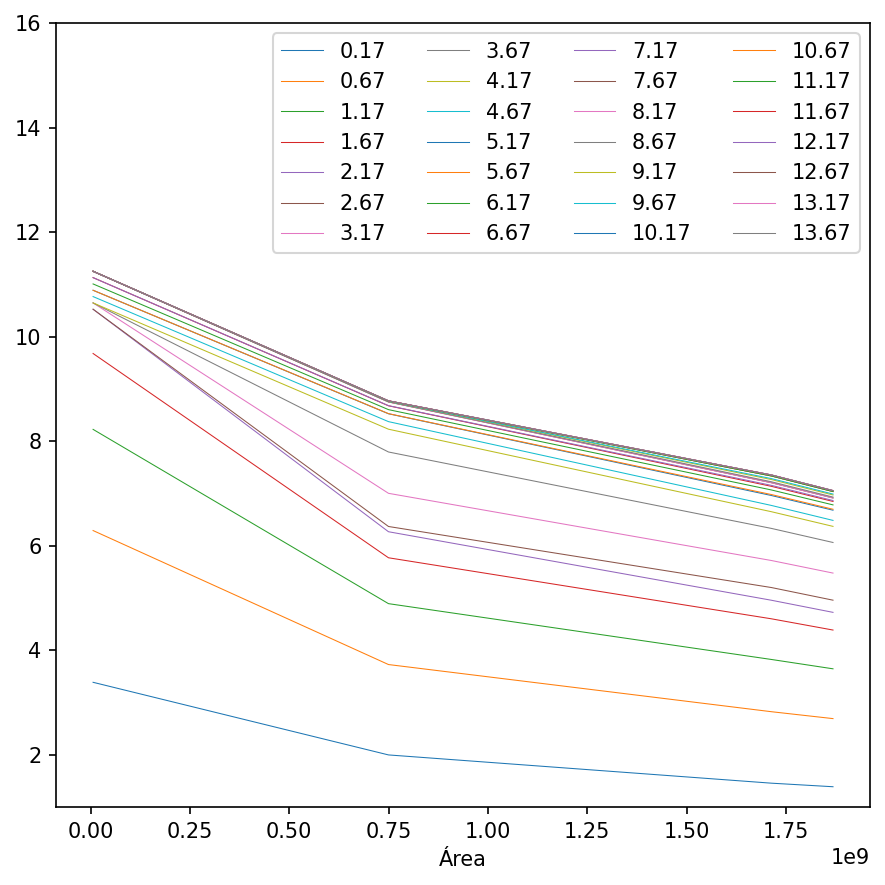

In [20]:
# Curvas h - a - d.

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(6, 6)
fig.set_dpi(150) 
# Graficamos una porción de las curvas h - a - d
h_a_d.iloc[ :, ::3 ].plot(ax = ax, linewidth = 0.5)
# Estilo.
handles, labels = ax.get_legend_handles_labels()
labels = [f"{float(x):.2f}" for x in labels]
ax.legend(handles, labels, ncol = 4)
ax.set_ylim(1, 16)
fig.tight_layout()
plt.show()

In [21]:
# Interpolamos para una área.

# Escogemos el área.
A = Subcuenca.loc[0, "AREA"] / 2
# Posición del área dentro de la curva h - a - d.
i = ( h_a_d.index > A ).sum()
# Porcentaje de avance entre los dos valores de área.
p = ( ( A - h_a_d.index[i - 1] )
    / ( h_a_d.index[i] - h_a_d.index[i - 1] ) )
# Interpolación lineal.
precipitacion_A = ( ( h_a_d.iloc[i] - h_a_d.iloc[i - 1] )
    * p + h_a_d.iloc[i - 1] )
# Se le da formato a la tabla de curva masa.
precipitacion_A.name = "curva masa [mm]"
precipitacion_A.index.name = "tiempo [h]"
precipitacion_A[0.0] = 0
precipitacion_A = precipitacion_A.sort_index()
precipitacion_A = pd.DataFrame( precipitacion_A )
# Calculamos el hietograma.
precipitacion_A["hp [mm]"] = ( precipitacion_A["curva masa [mm]"]
    - precipitacion_A["curva masa [mm]"].shift(1) )
precipitacion_A.loc[0.0, "hp [mm]"] = 0
precipitacion_A["i [mm/h]"] = precipitacion_A["hp [mm]"] / dt

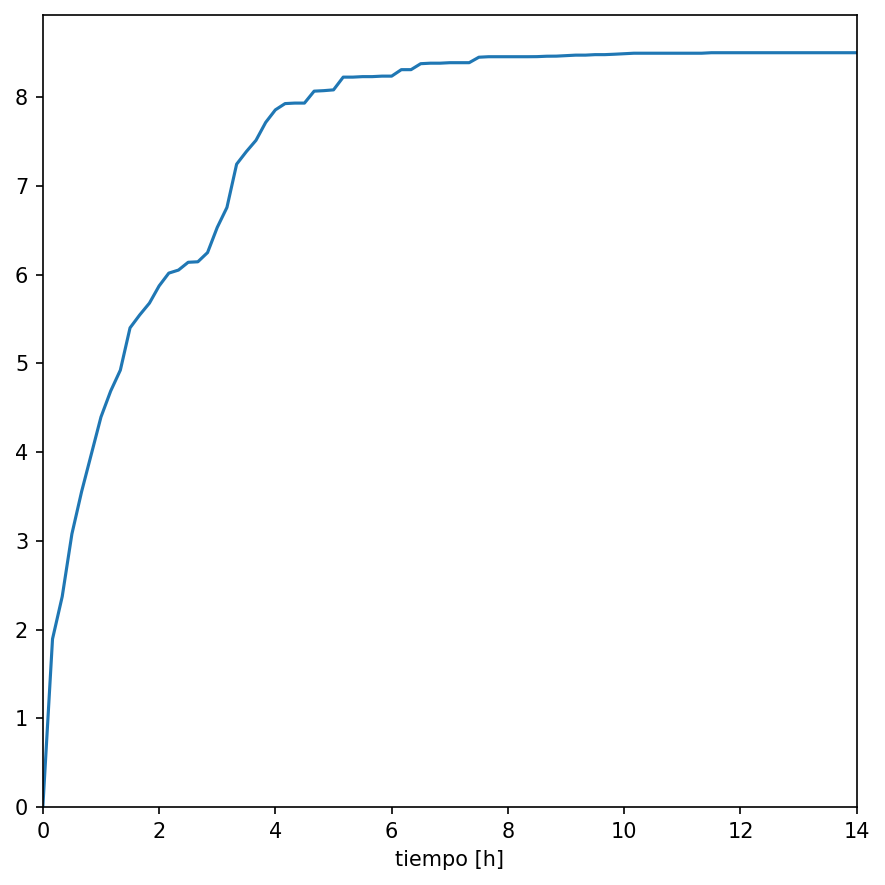

In [22]:
# Curva masa.

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(6, 6)
fig.set_dpi(150) 
# Graficamos la curva masa.
precipitacion_A["curva masa [mm]"].plot(ax = ax)
# Estilo.
ax.set_xlim(0, 14)
ax.set_ylim(0)
fig.tight_layout()
plt.show()

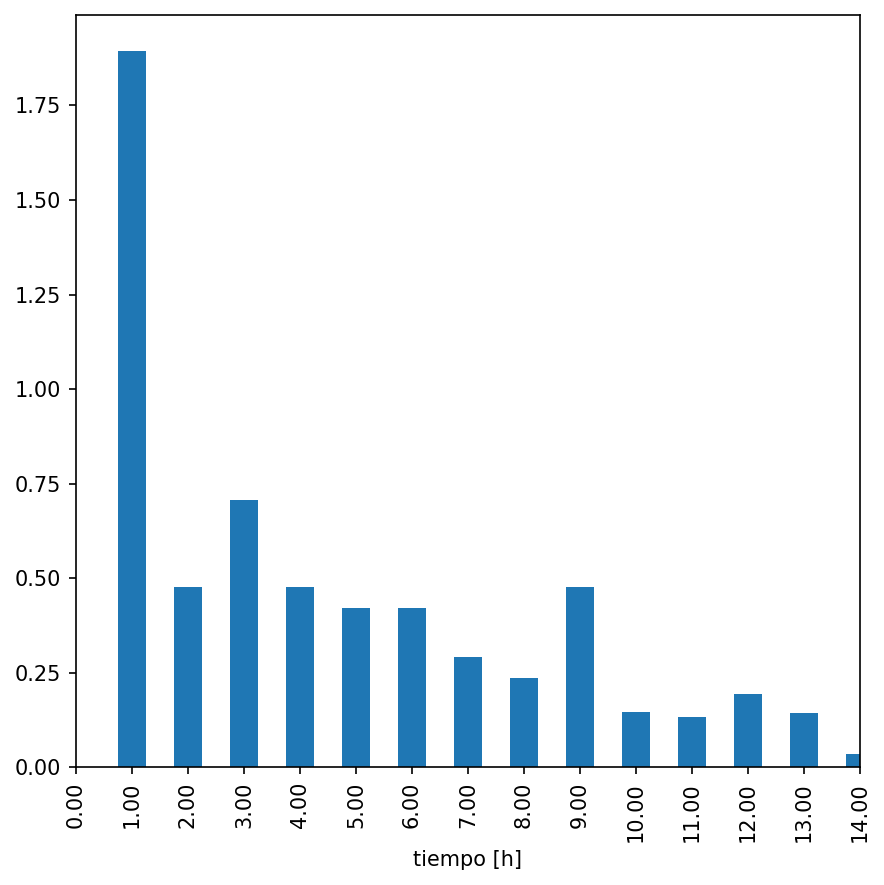

In [23]:
# Hietograma.

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(6, 6)
fig.set_dpi(150) 
# Graficamos el hietograma.
precipitacion_A["hp [mm]"].plot.bar(ax = ax)
# Estilo.
ax.set_xlim(0, 14)
ax.set_ylim(0)
ax.xaxis.set_major_formatter(plt.FormatStrFormatter("%.2f"))

fig.tight_layout()
plt.show()